In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read in the Mnist dataset

In [2]:
mnist_df = pd.read_csv("train.csv")
#We do not need the label from the dataset, drop it
mnist_df.drop(columns = "label", inplace = True)
#Convert the array into 0 to 1 scale
mnist_df = mnist_df.to_numpy(dtype='float32') / 255.0

## A simple Dataset class for our dataset

Creating a Dataset classes for our mnist dataset

In [5]:
class MnistDataset(data.Dataset):
    def __init__(self, mnist_df):
        super().__init__()
        self.db = mnist_df
    
    def __getitem__(self, index):
        return self.db[index]
    
    def __len__(self):
        return len(self.db)

In [6]:
dataset = MnistDataset(mnist_df)

### Visualize the dataset

After we initialize the dataset, the images in the dataset can be retrived through slicing

(784,)


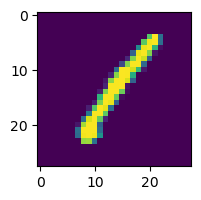

In [9]:
print(dataset[0].shape)
plt.figure(figsize=(2,2))
plt.imshow(dataset[0].reshape(28,28))

## Define Generator and Discriminator model

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100,256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256,784),
            nn.Tanh()
        )
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784,256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.model(x)

In [11]:
generator = Generator()
discriminator = Discriminator()

## Setting hyperparameter

- loss : Binary Cross Entropy
- batch_size : 32
- learning rate : 0.0001
- num_epochs : 10

In [12]:
criterion = nn.BCELoss()
lr = 0.0001
batch_size = 32
nBatches = len(dataset) // batch_size + 1
num_epochs = 10
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)
data_loader = data.DataLoader(dataset, batch_size = 32)

In [18]:
for epoch in range(num_epochs):
    for iterations, (real_samples) in enumerate(data_loader):
        #Sampled from noise
        noise = torch.FloatTensor(real_samples.shape[0], 100)
        noise.data.normal_(0,1)
        fake_samples = generator(noise)
        #Real labels are just one and fake labels are zeros
        real_label = torch.ones((real_samples.shape[0],1))
        fake_label = torch.zeros((real_samples.shape[0],1))
        
        #Training discrminator
        loss_discriminate = criterion(discriminator(torch.cat([real_samples, fake_samples])), 
                                      torch.cat([real_label, fake_label]))
        d_ability = 1 - discriminator(fake_samples).sum()/fake_samples.shape[0]
        
        if d_ability < 0.6:
            optimizer_discriminator.zero_grad()
            loss_discriminate.backward()
            optimizer_discriminator.step()
        
        #Training generator
        noise.data.normal_(0,1)
        fake_samples = generator(noise)
        loss_generator = criterion(discriminator(fake_samples), real_label)
        optimizer_generator.zero_grad()
        loss_generator.backward()
        optimizer_generator.step()
        g_ability = discriminator(fake_samples).sum()/fake_samples.shape[0]
        
        if iterations == 1000:

            print("Prediction ability for discriminator: {}".format(d_ability))
            print("Generation ability for generator: {}".format(g_ability))
            
    
    print("Epoch {}".format(epoch+1))
    

Prediction ability for discriminator: 0.6225070357322693
Generation ability for generator: 0.39548879861831665
Epoch 1
Prediction ability for discriminator: 0.6145167946815491
Generation ability for generator: 0.35371047258377075
Epoch 2
Prediction ability for discriminator: 0.6227203011512756
Generation ability for generator: 0.35029730200767517
Epoch 3
Prediction ability for discriminator: 0.5925155282020569
Generation ability for generator: 0.37316352128982544
Epoch 4
Prediction ability for discriminator: 0.5938630104064941
Generation ability for generator: 0.37051770091056824
Epoch 5
Prediction ability for discriminator: 0.6273385286331177
Generation ability for generator: 0.373218834400177
Epoch 6
Prediction ability for discriminator: 0.6010369062423706
Generation ability for generator: 0.38162970542907715
Epoch 7
Prediction ability for discriminator: 0.6258362531661987
Generation ability for generator: 0.40777647495269775
Epoch 8
Prediction ability for discriminator: 0.5815582871

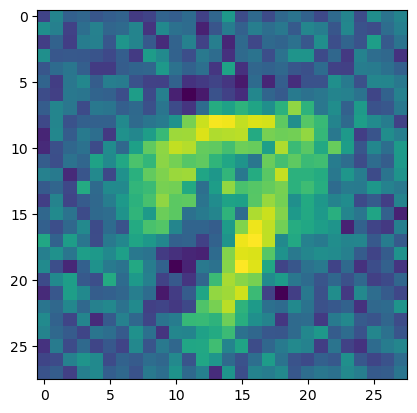

In [30]:
plt.imshow(generator(torch.randn((1,100))).reshape(28,28).detach().numpy())